In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import cv2
import pydicom as dicom
import matplotlib.pylab as plt
import matplotlib.patches as patches

from tqdm import tqdm
from collections import Counter
import os
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
train_labels_df = pd.read_csv('stage_2_train_labels.csv')
metadata_df = pd.read_csv("stage_2_detailed_class_info.csv")

In [3]:
dicom_image_path = './stage_2_train_images/'

In [4]:
# https://stackoverflow.com/questions/273192/how-can-i-safely-create-a-nested-directory-in-python
png_image_path='./stage_2_train_png_images/'
if not os.path.exists(png_image_path):
    os.makedirs(png_image_path)

In [5]:
## https://pycad.co/how-to-convert-a-dicom-image-into-jpg-or-png/
def convert_and_save_dcm_to_png(fileName):
    """
    Converts and saves DICOM image to PNG image in different directory which is pre-configured in the method implementation.
        
    Parameters
    ----------
    fileName : str
        this is hexadecimal file name from the dataset, this directly maps to CXR file provide with same name
    """
    im = dicom.dcmread(os.path.join(dicom_image_path,fileName+".dcm"))

    im = im.pixel_array.astype(float)

    rescaled_image = (np.maximum(im,0)/im.max())*255 # float pixels
    final_image = np.uint8(rescaled_image) # integers pixels

    final_image = Image.fromarray(final_image)
    final_image.save(os.path.join(png_image_path,fileName+".png"))
    return

In [6]:
%%time
patient_age_sex_dict={}

for i in tqdm(metadata_df['patientId'].values):
    convert_and_save_dcm_to_png(i)
    metadata = dicom.read_file(os.path.join(dicom_image_path,i+".dcm"))   
    patient_age_sex_dict[i] = [int(metadata.PatientAge),metadata.PatientSex]
    
patient_info_df = pd.DataFrame.from_dict(patient_age_sex_dict, orient="index").reset_index()
patient_info_df.columns=["patientId", "age", "sex"]

100%|██████████████████████████████████████████████████████████████████████████| 30227/30227 [00:25<00:00, 1208.90it/s]

Wall time: 25 s


In [7]:
patient_info_df.shape

(26684, 3)

In [8]:
patient_info_df.head()

,patientId,age,sex
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,51,F
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,48,F
2,00322d4d-1c29-4943-afc9-b6754be640eb,19,M
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,28,M
4,00436515-870c-4b36-a041-de91049b9ab4,32,F


In [9]:
patient_info_df = pd.merge(metadata_df,patient_info_df,on="patientId")
patient_info_df

,patientId,class,age,sex
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,51,F
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,48,F
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,19,M
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,28,M
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,32,F
...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity,54,M
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,Normal,46,F
30224,c1f6b555-2eb1-4231-98f6-50a963976431,Normal,45,M
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity,72,F


In [10]:
patient_info_df.to_csv("patient_info_df.csv")

In [11]:
patient_info_df= pd.read_csv("patient_info_df.csv", index_col=0)

In [12]:
patient_info_df.shape

(30227, 4)

In [13]:
patient_info_df

,patientId,class,age,sex
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,51,F
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,48,F
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,19,M
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,28,M
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,32,F
...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity,54,M
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,Normal,46,F
30224,c1f6b555-2eb1-4231-98f6-50a963976431,Normal,45,M
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity,72,F


In [14]:
merged_data_info = pd.merge(train_labels_df,patient_info_df,on="patientId")

In [15]:
merged_data_info.head()

,patientId,x,y,width,height,Target,class,age,sex
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,51,F
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,48,F
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,19,M
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,28,M
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,32,F


In [16]:
merged_data_info.shape

(37629, 9)

In [17]:
merged_data_df=merged_data_info.drop_duplicates(
  subset = ['patientId', 'x','y'],
  keep = 'last').reset_index(drop = True)

In [18]:
merged_data_df.shape

(30227, 9)

In [19]:
merged_data_df.head(10)

,patientId,x,y,width,height,Target,class,age,sex
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,51,F
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,48,F
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,19,M
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,28,M
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,32,F
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,32,F
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,54,M
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,78,M
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,75,M
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,75,M


In [20]:
# https://stackoverflow.com/a/56850914/1225413
condition = merged_data_df['sex'] == "M"
merged_data_df.loc[condition, 'sex'] = "Male"

condition = merged_data_df['sex'] == "F"
merged_data_df.loc[condition, 'sex'] = "Female"

In [21]:
merged_data_df

,patientId,x,y,width,height,Target,class,age,sex
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,51,Female
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,48,Female
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,19,Male
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,28,Male
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,32,Female
...,...,...,...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1,Lung Opacity,54,Male
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0,Normal,46,Female
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0,Normal,45,Male
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity,72,Female


In [22]:
merged_data_df["age"] = merged_data_df["age"].astype('float')

In [23]:
merged_data_df.to_csv("merged_data.csv")

In [3]:
merged_data_df= pd.read_csv("merged_data.csv", index_col=0)

In [4]:
merged_data_df.head(10)

,patientId,x,y,width,height,Target,class,age,sex
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,51.0,Female
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,48.0,Female
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,19.0,Male
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,28.0,Male
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,32.0,Female
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,32.0,Female
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,54.0,Male
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,78.0,Male
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,75.0,Male
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,75.0,Male


In [26]:
merged_data_df.describe()

,x,y,width,height,Target,age
count,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000,30227.000000
mean,394.047724,366.839560,218.471376,329.269702,0.316108,46.797764
std,204.574172,148.940488,59.289475,157.750755,0.464963,16.892940
min,2.000000,2.000000,40.000000,45.000000,0.000000,1.000000
25%,207.000000,249.000000,177.000000,203.000000,0.000000,34.000000
50%,324.000000,365.000000,217.000000,298.000000,0.000000,49.000000
75%,594.000000,478.500000,259.000000,438.000000,1.000000,59.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000,155.000000


In [27]:
merged_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 30226
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
 7   age        30227 non-null  float64
 8   sex        30227 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 2.3+ MB


<h3>Observations:</h3>

<ol>
    <li>Minimun age in dataset is : <b>1</b> &amp; Maximum is : <b>155</b></li>
    <li>Mean age is : <b>46</b></li>
    <li>Average bounding box dimension is around : <b>(219.266675, 337.799552)</b></li>
</ol>    

In [28]:
# https://stackoverflow.com/a/62053049/1225413
def without_hue(plot, feature):
    """
    Prints the percentage above the bar in the given plot for given data feature.
        
    Parameters
    ----------
    plot : matplotlib plot object
        The plot where we need to add information.
    feature : pandas.Series
        Particular feature series for which we have to add percentage above the bar.
    """
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = (p.get_y() + p.get_height())+200
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

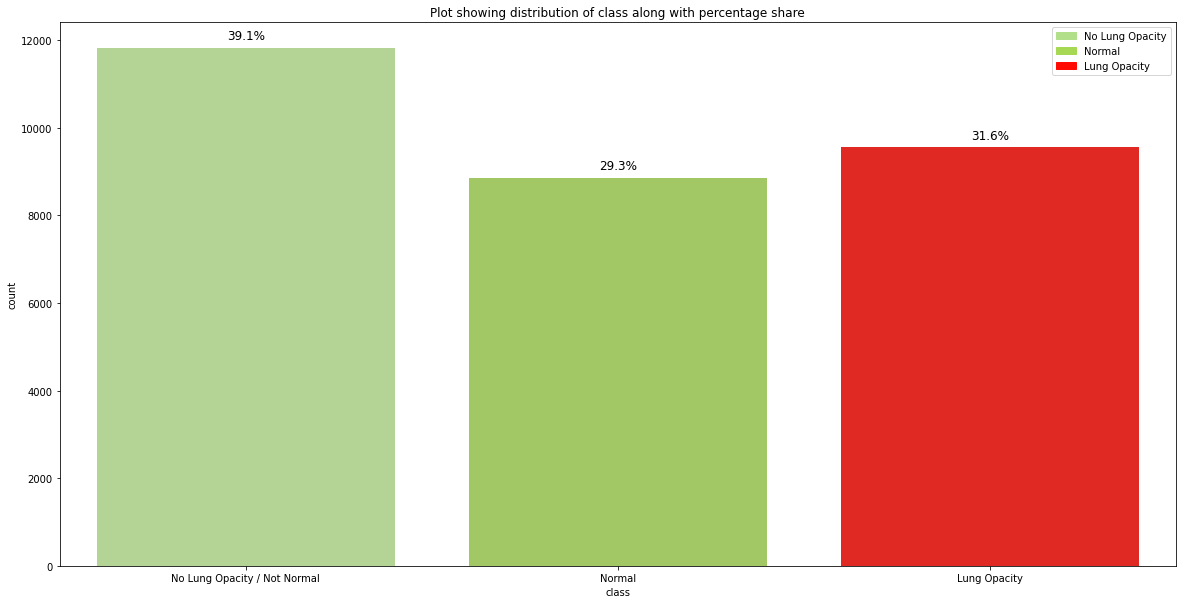

In [29]:
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)

# https://towardsdatascience.com/how-to-use-your-own-color-palettes-with-seaborn-a45bf5175146
# Create an array with the colors you want to use
colors = ["#b2df8a", "#a6d854", "#FF0B04"]
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

# https://stackoverflow.com/a/60388433/1225413
class_1_patch = patches.Patch(color='#b2df8a', label='No Lung Opacity')
class_2_patch = patches.Patch(color='#a6d854', label='Normal')
class_3_patch = patches.Patch(color='#FF0B04', label='Lung Opacity')

# https://seaborn.pydata.org/generated/seaborn.countplot.html
# Use the parameter palette and use your own palette across all plots
g=sns.countplot(data=merged_data_df, x='class', ax=ax, palette=customPalette)
g.set(title="Plot showing distribution of class along with percentage share")

g.legend(loc='upper right',handles=[class_1_patch, class_2_patch, class_3_patch])

without_hue(g, merged_data_df["class"])

<h3>Observation:</h3>
<ol>
    <li>Only 31.6% of data have patients with Pneumonia</li>
    <li>No Lung Opacity &amp; Normal together contribute to 68.4%</li>
<ol>

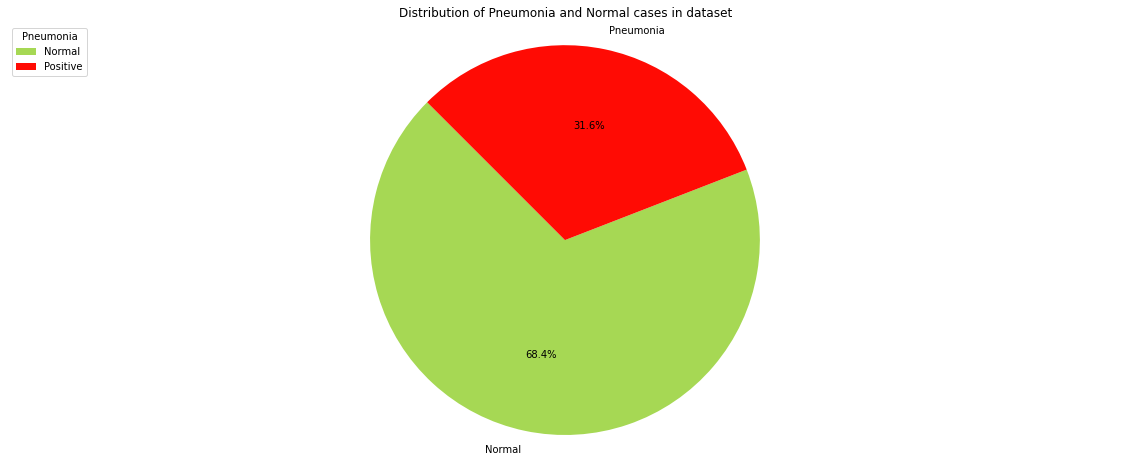

In [55]:
label_count=merged_data_df['Target'].value_counts()

fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)

ax.pie(label_count.values, labels=['Normal','Pneumonia'], autopct='%1.1f%%', startangle=135)
ax.axis('equal') 

ax.legend(title='Pneumonia', loc='upper left', labels=['Normal', 'Positive'])

plt.title('Distribution of Pneumonia and Normal cases in dataset')
plt.show()

<h3>Observation:</h3>

Very less data actually have Pneumonia as positive. We have to augment more number of positive cases to train the model for better fit.

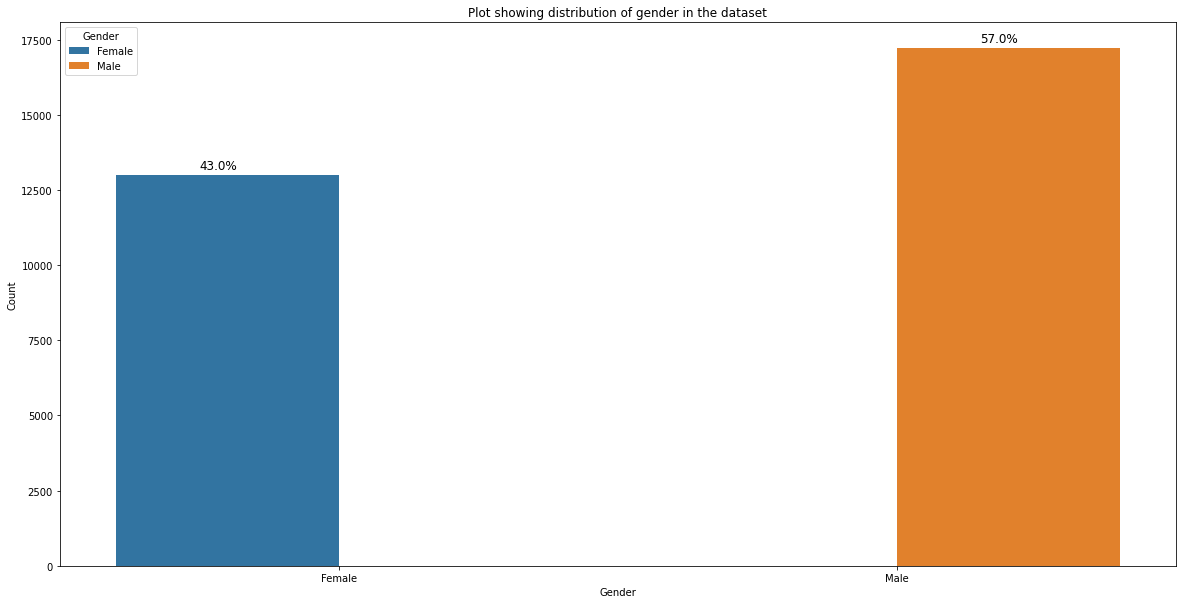

In [31]:
sns.set_palette("tab10")

fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)


g=sns.countplot(data=merged_data_df, x='sex', ax=ax, hue="sex")
legend_labels, _= g.get_legend_handles_labels()
g.legend(legend_labels, ['Female', 'Male'], title="Gender")

g.set(xlabel="Gender", ylabel="Count", title="Plot showing distribution of gender in the dataset")

without_hue(g, merged_data_df["sex"])

<h3>Observation:</h3> 

The data has more Male folks, around 14% more. <br/> We need to further explore how much of cases are positive or negative by gender.

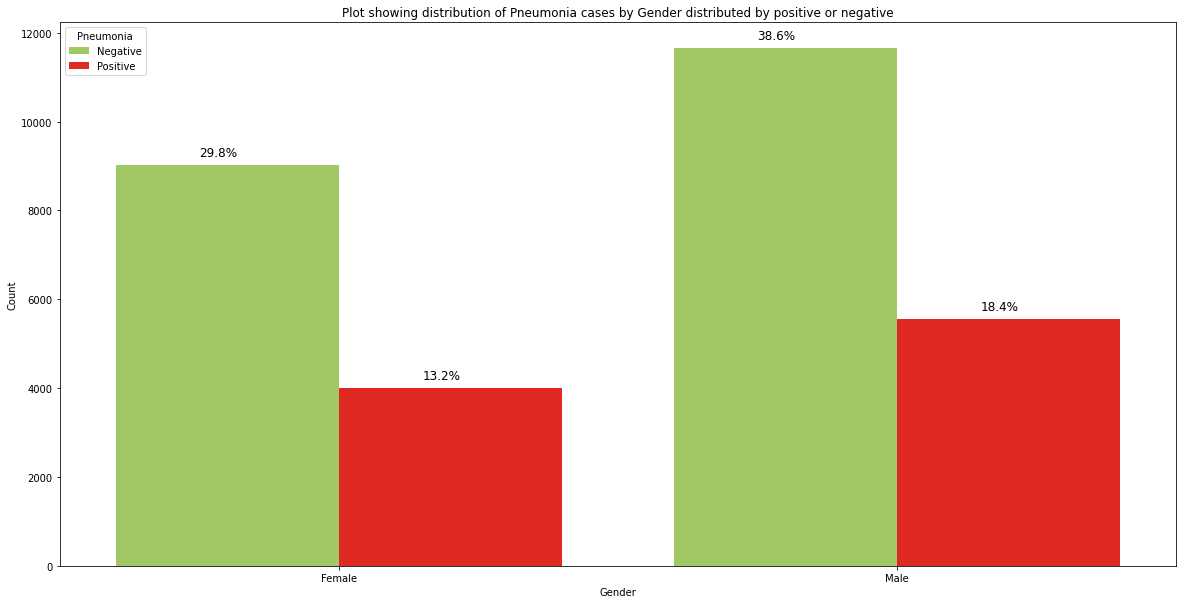

In [64]:
# https://stackoverflow.com/a/48958510/1225413
sns.set_palette("tab10")

colors = ["#a6d854", "#FF0B04"]
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)

g=sns.countplot(data=merged_data_df, x='sex', ax=ax, hue="Target")

# https://stackoverflow.com/a/55108651/1225413
g.legend(title='Pneumonia', loc='upper left', labels=['Negative', 'Positive'])
g.set(xlabel="Gender", ylabel="Count", title="Plot showing distribution of Pneumonia cases by Gender distributed by positive or negative")

without_hue(g, merged_data_df["sex"])

In [33]:
merged_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 30226
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
 7   age        30227 non-null  float64
 8   sex        30227 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 3.3+ MB


[Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Plot showing distribution of Age in the dataset')]

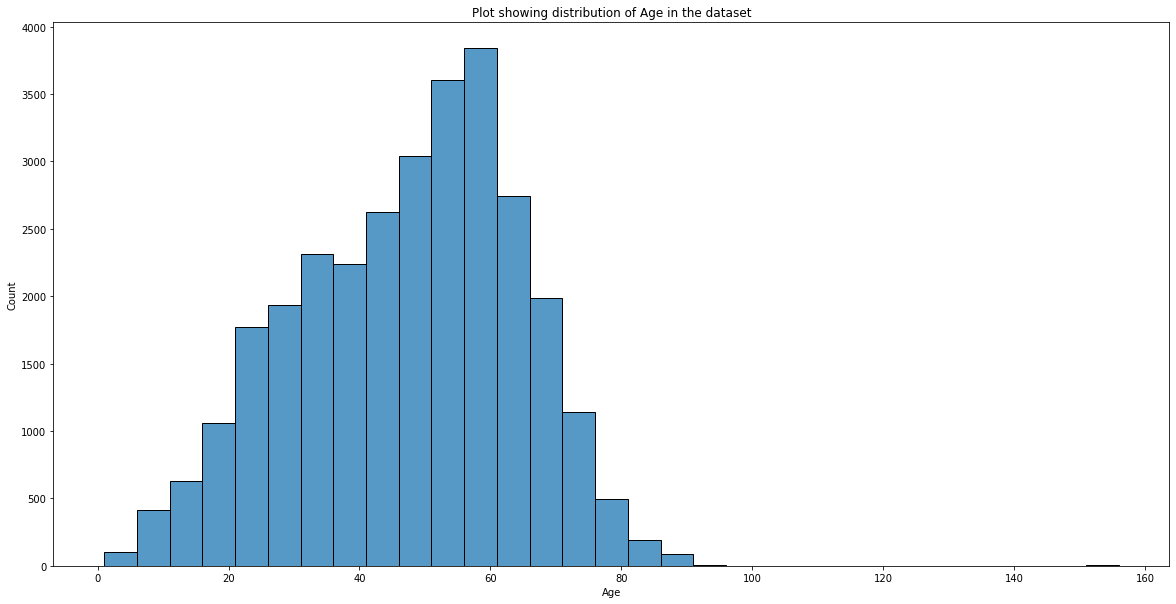

In [56]:
sns.set_palette("tab10")

fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)

g=sns.histplot(data=merged_data_df, x="age", ax=ax, binwidth=5,)

g.set(xlabel="Age", ylabel="Count", title="Plot showing distribution of Age in the dataset")

[Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Plot showing distribution of Age in the dataset')]

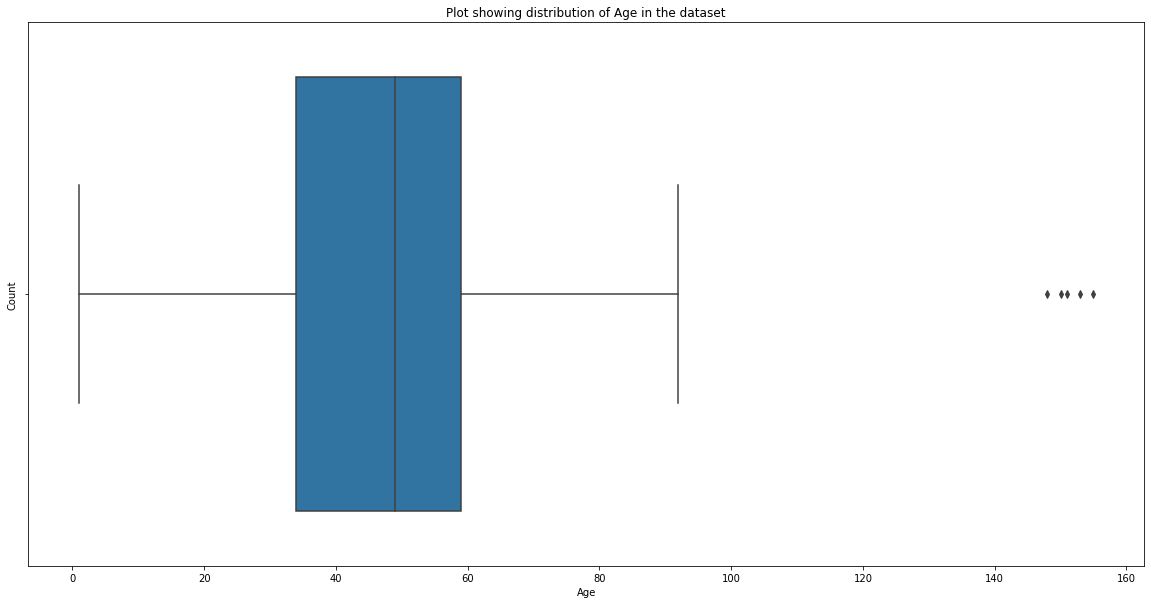

In [57]:
sns.set_palette("tab10")

fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)

g=sns.boxplot(data=merged_data_df, x="age", ax=ax)

g.set(xlabel="Age", ylabel="Count", title="Plot showing distribution of Age in the dataset")

In [36]:
def print_quartiles(data):
    #print 0 to 100 percentile values with step size of 10 for train data duration.
    for i in range(0,125, 25):
        print(i,'percentile value is',np.percentile(data,i))

def print_0to100_percentile(data):
    #print 0 to 100 percentile values with step size of 10 for train data duration.
    for i in range(0,11):
        print(10*i,'percentile value is',np.percentile(data,10*i))

def print_99to100_percentile(data):
    ##print 90 to 100 percentile values with step size of 1.
    for i in range(0,11):
        print(99+(i/10),'percentile value is',np.percentile(data,99+(i/10)))

In [37]:
print("Descriptive Stats on Age\n")

print_quartiles(merged_data_df["age"])
print("-"*50)
print_0to100_percentile(merged_data_df["age"])
print("-"*50)
print_99to100_percentile(merged_data_df["age"])

Descriptive Stats on Age

0 percentile value is 1.0
25 percentile value is 34.0
50 percentile value is 49.0
75 percentile value is 59.0
100 percentile value is 155.0
--------------------------------------------------
0 percentile value is 1.0
10 percentile value is 23.0
20 percentile value is 31.0
30 percentile value is 38.0
40 percentile value is 44.0
50 percentile value is 49.0
60 percentile value is 53.0
70 percentile value is 57.0
80 percentile value is 62.0
90 percentile value is 67.0
100 percentile value is 155.0
--------------------------------------------------
99.0 percentile value is 80.0
99.1 percentile value is 81.0
99.2 percentile value is 81.0
99.3 percentile value is 81.0
99.4 percentile value is 82.0
99.5 percentile value is 83.0
99.6 percentile value is 84.0
99.7 percentile value is 86.0
99.8 percentile value is 87.0
99.9 percentile value is 89.0
100.0 percentile value is 155.0


<h3>Observation: </h3>

The data has outlier points as few points how age above 140.
We can see even after 99.9 the age directly jumps to 155, we need to further as to where we can keep the data and trip outlier points.

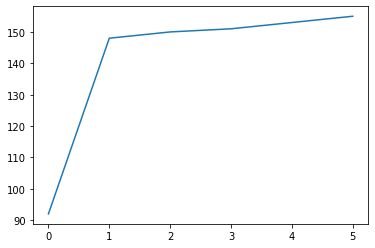

In [58]:
var = merged_data_df["age"].values
var = np.sort(var,axis = None)
plt.plot(var[-6:])
plt.show()

<h3>Observation: </h3>

The last age is 90 and the 5 points after that are outliers.

[Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Plot showing distribution of Age for Male Gender in the dataset')]

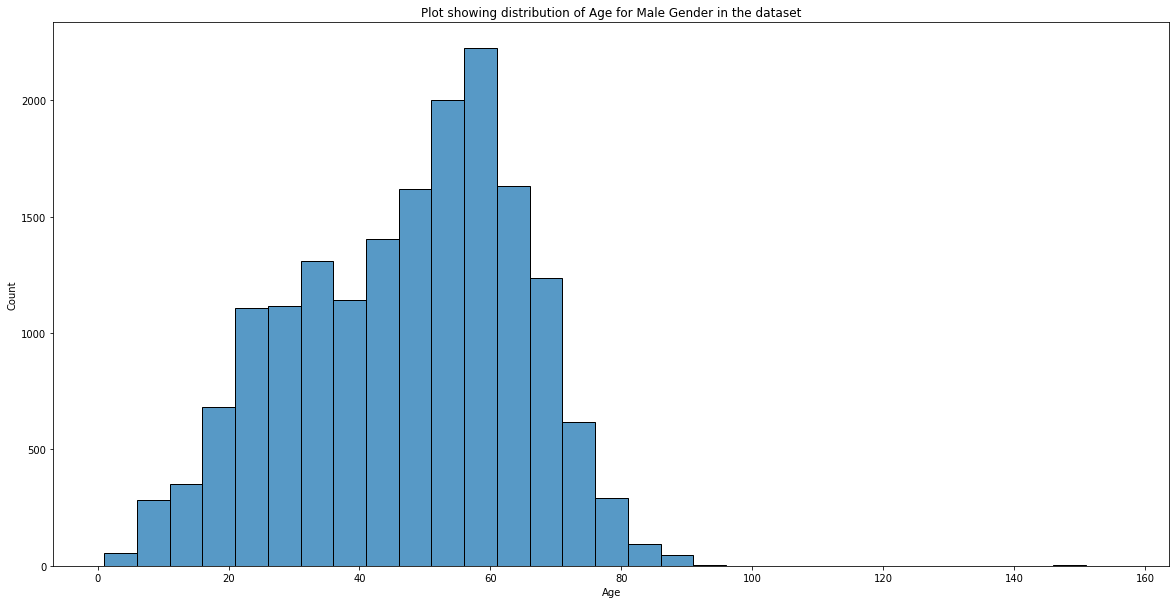

In [59]:
male_df=merged_data_df.loc[merged_data_df.sex =="Male"]

fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)

g=sns.histplot(data=male_df, x="age", ax=ax, binwidth=5,)

g.set(xlabel="Age", ylabel="Count", title="Plot showing distribution of Age for Male Gender in the dataset")

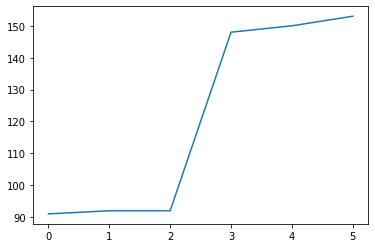

In [60]:
var = male_df["age"].values
var = np.sort(var,axis = None)
plt.plot(var[-6:])
plt.show()

<h3>Observation: </h3>

The last age is the dataset is 90 and that patient is male who was checked for Pneumonia.

[Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Plot showing distribution of Age for Male Gender differentiate on Pneumonia')]

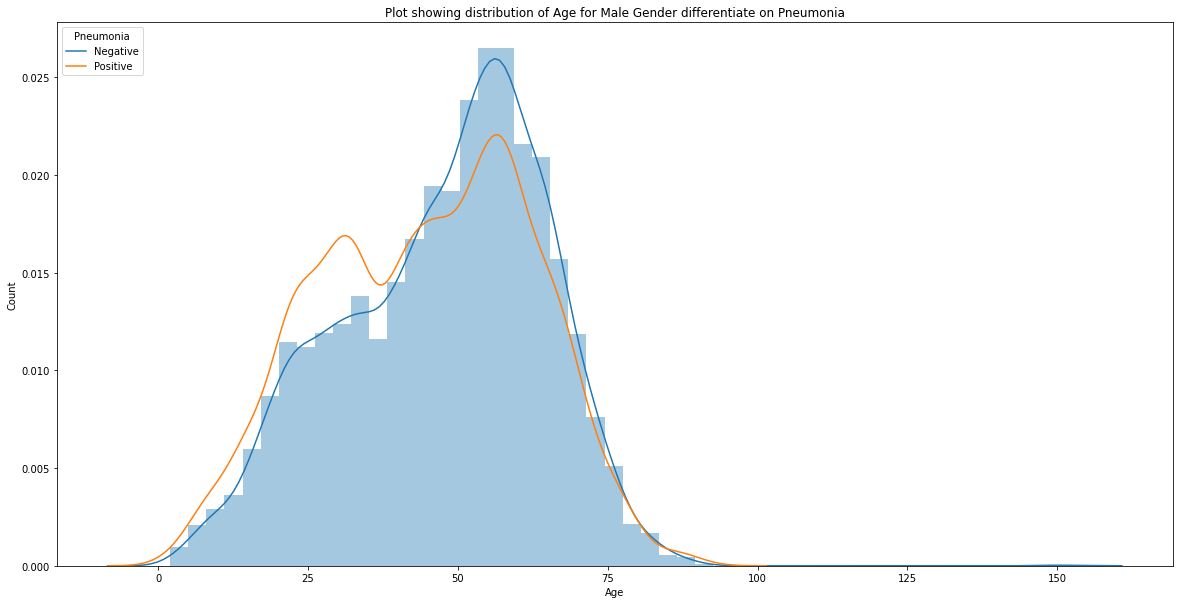

In [61]:
# https://stackoverflow.com/a/46046103/1225413
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)

target_0 = male_df.loc[male_df['Target'] == 0]
target_1 = male_df.loc[male_df['Target'] == 1]

sns.distplot(target_0[["age"]], kde=True, ax=ax)
g=sns.distplot(target_1[["age"]], hist=False,)
g.legend(title='Pneumonia', loc='upper left', labels=['Negative', 'Positive'])

g.set(xlabel="Age", ylabel="Count", title="Plot showing distribution of Age for Male Gender differentiate on Pneumonia")

In [42]:
print("Descriptive Stats on Age for Male Gender\n")

print_quartiles(male_df["age"])
print("-"*50)
print_0to100_percentile(male_df["age"])
print("-"*50)
print_99to100_percentile(male_df["age"])

Descriptive Stats on Age for Male Gender

0 percentile value is 1.0
25 percentile value is 33.0
50 percentile value is 49.0
75 percentile value is 59.0
100 percentile value is 153.0
--------------------------------------------------
0 percentile value is 1.0
10 percentile value is 22.0
20 percentile value is 30.0
30 percentile value is 37.0
40 percentile value is 44.0
50 percentile value is 49.0
60 percentile value is 54.0
70 percentile value is 58.0
80 percentile value is 62.0
90 percentile value is 67.0
100 percentile value is 153.0
--------------------------------------------------
99.0 percentile value is 79.0
99.1 percentile value is 80.0
99.2 percentile value is 81.0
99.3 percentile value is 81.0
99.4 percentile value is 82.0
99.5 percentile value is 83.0
99.6 percentile value is 84.0
99.7 percentile value is 86.0
99.8 percentile value is 87.0
99.9 percentile value is 88.0
100.0 percentile value is 153.0


<h3>Plotting charts for Female gender</h3>

[Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Plot showing distribution of Age for Female Gender in the dataset')]

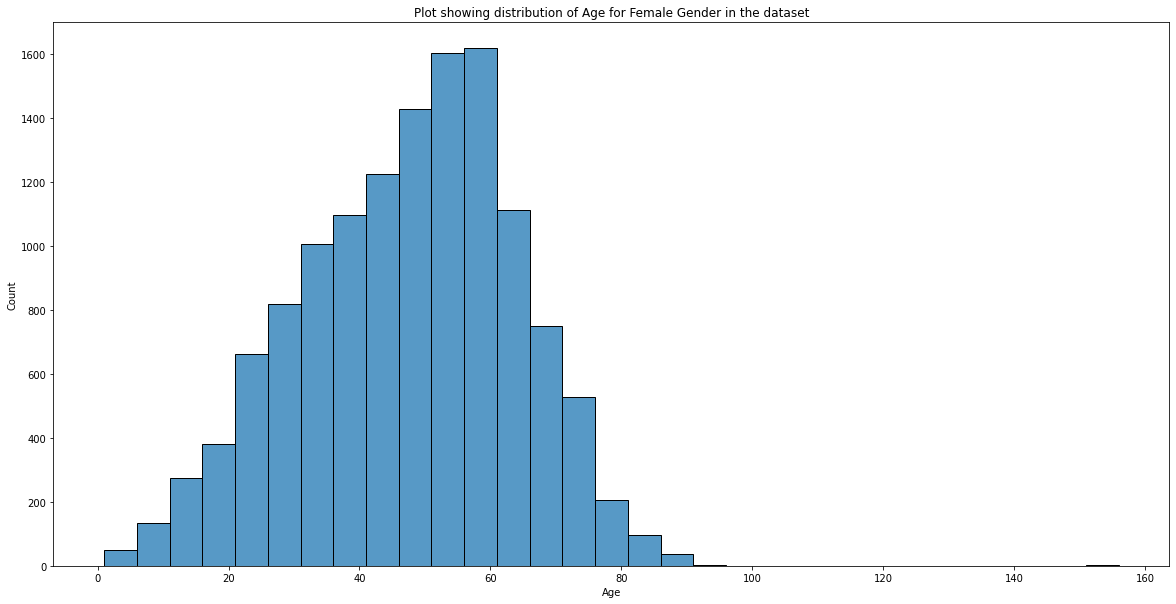

In [62]:
female_df=merged_data_df.loc[merged_data_df.sex =="Female"]

fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)

g=sns.histplot(data=female_df, x="age", ax=ax, binwidth=5,)
g.set(xlabel="Age", ylabel="Count", title="Plot showing distribution of Age for Female Gender in the dataset")

[Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Plot showing distribution of Age for Female Gender differentiate on Pneumonia')]

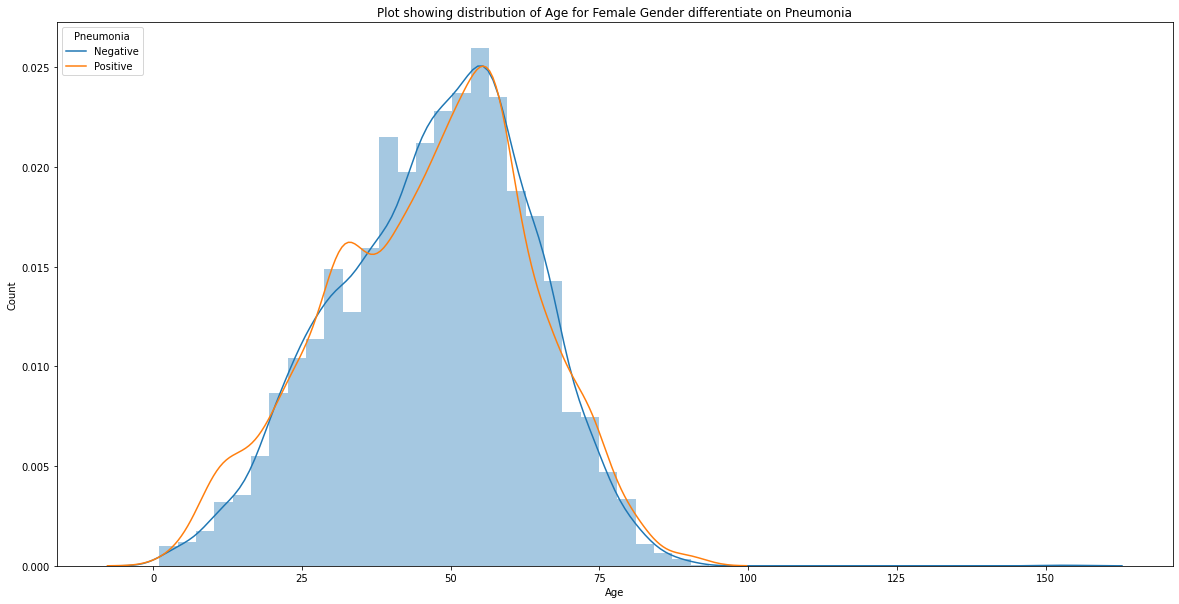

In [63]:
# https://stackoverflow.com/a/46046103/1225413
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)

target_0 = female_df.loc[female_df['Target'] == 0]
target_1 = female_df.loc[female_df['Target'] == 1]

sns.distplot(target_0[["age"]], kde=True, ax=ax)
g=sns.distplot(target_1[["age"]], hist=False,)
g.legend(title='Pneumonia', loc='upper left', labels=['Negative', 'Positive'])

g.set(xlabel="Age", ylabel="Count", title="Plot showing distribution of Age for Female Gender differentiate on Pneumonia")

In [45]:
print("Descriptive Stats on Age for Female Gender\n")

print_quartiles(female_df["age"])
print("-"*50)
print_0to100_percentile(female_df["age"])
print("-"*50)
print_99to100_percentile(female_df["age"])

Descriptive Stats on Age for Female Gender

0 percentile value is 1.0
25 percentile value is 35.0
50 percentile value is 49.0
75 percentile value is 59.0
100 percentile value is 155.0
--------------------------------------------------
0 percentile value is 1.0
10 percentile value is 24.0
20 percentile value is 32.0
30 percentile value is 38.0
40 percentile value is 44.0
50 percentile value is 49.0
60 percentile value is 53.0
70 percentile value is 57.0
80 percentile value is 61.0
90 percentile value is 67.0
100 percentile value is 155.0
--------------------------------------------------
99.0 percentile value is 81.0
99.1 percentile value is 81.0
99.2 percentile value is 81.0
99.3 percentile value is 81.0
99.4 percentile value is 82.0
99.5 percentile value is 83.0
99.6 percentile value is 83.0
99.7 percentile value is 85.96999999999935
99.8 percentile value is 87.0
99.9 percentile value is 90.0
100.0 percentile value is 155.0


<h3>Observation:</h3>

The number of female population where both have positive or negative pneumonia is at peak are vey close. Such was not the case with male population as there was some gap between the point the distribution was at peak for positive and negative cases.

<h3>EDA on number of bounding boxes </h3>

In [30]:
merged_data_df.groupby(['patientId']).count().value_counts()

x  y  width  height  Target  class  age  sex
0  0  0      0       1       1      1    1      20672
2  2  2      2       2       2      2    2       3266
1  1  1      1       1       1      1    1       2614
3  3  3      3       3       3      3    3        119
4  4  4      4       4       4      4    4         13
dtype: int64

In [12]:
merged_data_df.groupby("patientId").size().sort_values(ascending=False)

patientId
76f71a93-8105-4c79-a010-0cfa86f0061a    4
1bf08f3b-a273-4f51-bafa-b55ada2c23b5    4
0ab261f9-4eb5-42ab-a9a5-e918904d6356    4
0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d    4
1c44e0a4-4612-438f-9a83-8d5bf919cb67    4
                                       ..
6b1319bc-6253-47b8-9f36-c694bef288d0    1
6b110a37-e31c-437d-8886-c2e7cd5b2cb2    1
6b10737e-ec37-4f37-8db3-a95434db6016    1
6b0fa27d-7ca7-4b56-92c7-a389988ec660    1
fffec09e-8a4a-48b1-b33e-ab4890ccd136    1
Length: 26684, dtype: int64

<h3>Observation:</h3>

The maximum bounding box present in any image is 4. And there 13 such images. <br/>
Similarly, 119 images have 3 bounding boxes and 20K+ images have Zero bounding boxes.

<h3>Visualize Images/Chest scans</h3>

In [46]:
# https://www.kaggle.com/kiwifairy/visualize-x-ray-image-with-bounding-boxes/notebook
def plot_img_bounding_box(img, boxes_df):
    """
    The method plot bounding box(es) around image based on the dimension provided in the dataset.
    Parameters
    ----------
    img : numpy.ndarray
        numpy array representation of DICOM image.
    boxes_df : pandas.DataFrame
        The DataFrame which contains information of bounding box(es) which needs to be plotted on image.
    """    
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(10,10)
    a.imshow(img, cmap = 'gray')
    for index, row in boxes_df.iterrows():
        x, y, width, height  = row['x'], row['y'], row['width'], row['height']
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    
    plt.title("Grayscale image with bounding box")
    plt.show()

In [47]:
def plot_random_sample_with_bounding_box(dataframe):
    """
    The method automatically picks random sample image from dataset where Target=1 i.e., where pneumonia is present and plot
    2 images for that random sample. 1-CXR image, 2-BW image with bounding box(es) on the image.
    Parameters
    ----------
    img : numpy.ndarray
        numpy array representation of DICOM image.
    boxes_df : pandas.DataFrame
        The DataFrame which contains information of bounding box(es) which needs to be plotted on image.
    """        
    sample_df=dataframe[dataframe.Target == 1].sample(1) 
    
    # https://stackoverflow.com/a/61770326/1225413
    # specify your image path
    image_path = './stage_2_train_images/'+list(sample_df["patientId"])[0]+'.dcm'
    ds = dicom.dcmread(image_path)

#     https://stackoverflow.com/a/61572985/1225413
    plt.figure(figsize = (10,10))
    plt.imshow(ds.pixel_array)
    plt.title("DICOM Image")
    
    image = ds.pixel_array
    plot_img_bounding_box(image, sample_df)

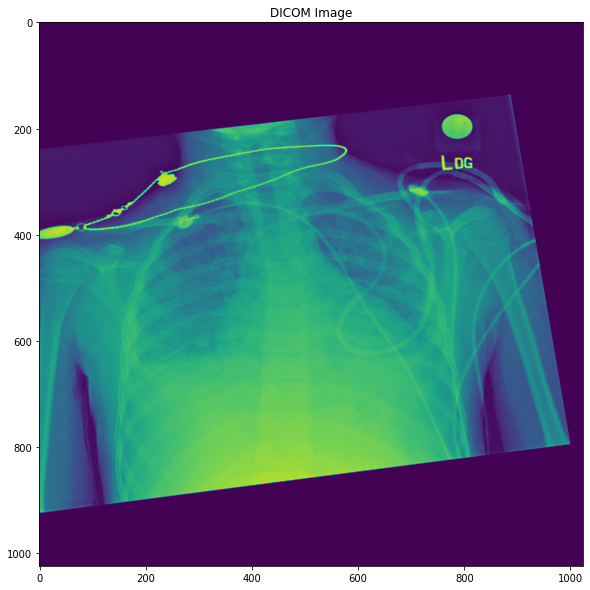

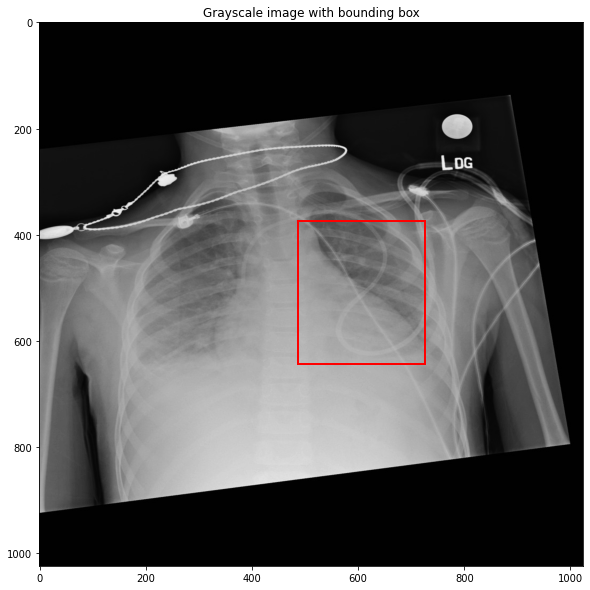

In [48]:
plot_random_sample_with_bounding_box(merged_data_df)

In [65]:
def adding_bounding_boxes_to_plot(ax, x, y, width, height):
    """
    The method creates bounding box on the axes passed and bounding details.
    Parameters
    ----------
    ax : matplotlib.axes
        numpy array representation of DICOM image.
    x : float
        x-coordiante of bounding box.
    y : float
        y-coordiante of bounding box..
    width : float
        width of bounding box.
    height : float
        height of bounding box.
    """    
    rect = patches.Rectangle((x, y), width, height, linewidth = 2, edgecolor = 'r', facecolor = 'none')
    # Draw the bounding box on top of the image
    ax.add_patch(rect)
    return

In [50]:
merged_data_df[0:3]

,patientId,x,y,width,height,Target,class,age,sex
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,51.0,Female
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,48.0,Female
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,19.0,Male


In [51]:
type(merged_data_df.loc[0:0]["x"])

pandas.core.series.Series

In [66]:
def plot_x_random_images(dataframe, no_of_images):
    """
    The method automatically plot random sample B/W images from given pandas Dataframe.
    It plots multiple images based on number of images passed.
    It also plots bounding box around the CXR image if the sample data is Pneumonia case.
    
    Parameters
    ----------
    dataframe : pandas.DataFrame
        numpy array representation of DICOM image.
    no_of_images : int
        number of images that needed to be plotted.    
    """
    for i in range(0, no_of_images):
        sample_df=dataframe.sample(3)                
        image_path_1 = './stage_2_train_images/'+list(sample_df["patientId"])[0]+'.dcm'
        image_path_2 = './stage_2_train_images/'+list(sample_df["patientId"])[1]+'.dcm'
        image_path_3 = './stage_2_train_images/'+list(sample_df["patientId"])[2]+'.dcm'

        plt.figure(figsize = (15, 6))

        if((3*i)+1<=no_of_images):
            ax=plt.subplot(131)
            plt.title(list(sample_df["class"])[0])
            if(list(sample_df["Target"])[0]==1):
                x = list(sample_df["x"])[0]
                y = list(sample_df["y"])[0]
                width = list(sample_df["width"])[0]
                height = list(sample_df["height"])[0]
                adding_bounding_boxes_to_plot(ax, x, y, width, height)
            plt.imshow(dicom.dcmread(image_path_1).pixel_array, cmap = 'gray')
        else:
            return
        
        if((3*i)+2<=no_of_images):
            ax=plt.subplot(132)
            plt.title(list(sample_df["class"])[1])
            if(list(sample_df["Target"])[1]==1):
                x = list(sample_df["x"])[1]
                y = list(sample_df["y"])[1]
                width = list(sample_df["width"])[1]
                height = list(sample_df["height"])[1]
                adding_bounding_boxes_to_plot(ax, x, y, width, height)
            plt.imshow(dicom.dcmread(image_path_2).pixel_array, cmap = 'gray')
        else:
            return
    
        if((3*i)+3<=no_of_images):
            ax=plt.subplot(133)
            plt.title(list(sample_df["class"])[2])
            if(list(sample_df["Target"])[2]==1):
                x = list(sample_df["x"])[2]
                y = list(sample_df["y"])[2]
                width = list(sample_df["width"])[2]
                height = list(sample_df["height"])[2]
                adding_bounding_boxes_to_plot(ax, x, y, width, height)
            plt.imshow(dicom.dcmread(image_path_3).pixel_array, cmap = 'gray')
        else:
            return
        
        plt.show()

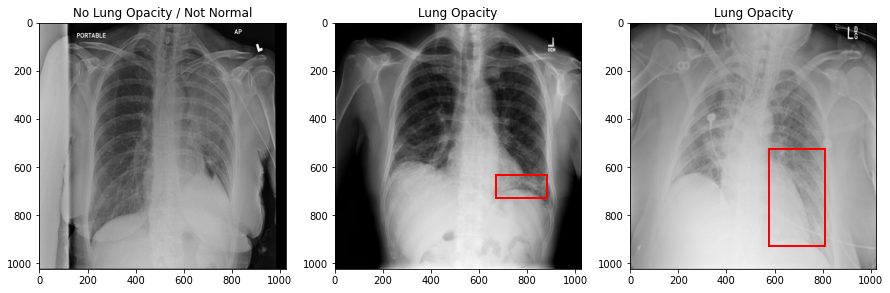

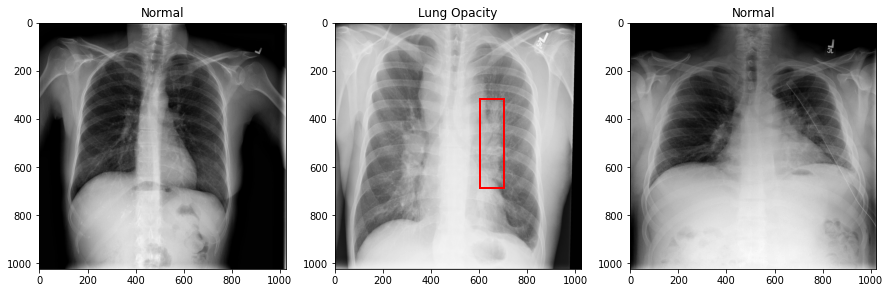

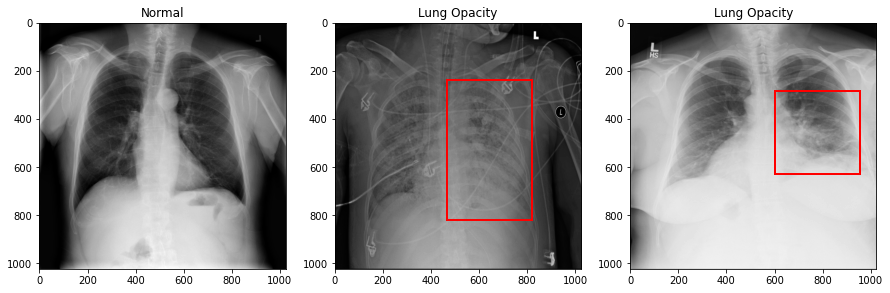

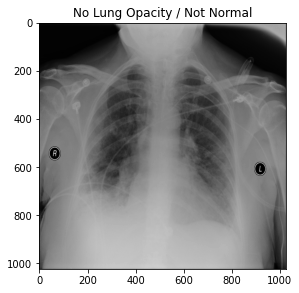

In [67]:
plot_x_random_images(merged_data_df, no_of_images=10)